<h1> Spectral Properties of Graphs </h1><br> PHYS7332 Network Science Data Project | Mostafa Alkady

<div style="text-align: center;">
  <img src="images/intro.png" alt="Snowfall" width="400" height="400">
</div>

### Goals of today's class:
1- Understand the relation between graph spectra and graph structures <br>
2- Use spectral graph theory techniques in different applications of network science. <br>
3- Get to know the venues SGT can open in network analysis in general.

### Please note..
- This is a <b>practical</b> introduction to the spectral properties of networks. Proofs will be skipped, but resources for further readings will be provided.
- Familiarity with the basics of Linear Algebra is assumed.

## Table of Contents
* [Ch. 1: The Unreasonable Effectiveness of Spectral Graph Theory](#ch1) <br>
* [Ch. 2: Adjacency Matrix](#ch2)
    * [Definition](#adj_definition)
    * [Normalized Adjacency Matrix](#A_norm)
    * [Properties of $A_\text{norm}$](#prop_a_norm)
    * [Community Structure & Fiedler Vector](#a_norm_comm)
    * [Random Walks](#a_norm_random_walk)
* [Ch. 3: Laplacian Matrix](#ch3)
    * [Definition](#lap_definition)
    * [Properties of L_norm](#prop_l_norm)
    * [Laplacian Spectrum of Standard Graphs](#laplacian_spectrum)
    * [Relation Between $A_\text{norm}$ and $L_\text{norm}$](#relation)
    * [Bottlenecks, Sparse Cuts and Cheeger's Inequality](#sparse-cuts)
    * [Optimization Formulation for $\lambda_2$](#optimization)
* [Ch. 4: Non-Backtracking Matrix](#ch4)
    * [Definition](#nb-definition)
    * [Applications](#nb-applications)
* Resources & Answers to Exercises

## Chapter 1: The Unreasonable Effectiveness of Spectral Graph Theory <a class="anchor" id="ch1"></a>

Spectral graph theory (SGT) is a branch of mathematics that studies the relationships between the structure of a graph and the eigenvalues and eigenvectors of matrices associated with it, such as the adjacency matrix, the Laplacian matrix, and their normalized counterparts. These matrices encode the connectivity and interactions between nodes, making spectral methods an essential tool for understanding both the local and global properties of graphs. The field provides a bridge between algebra, geometry, and graph theory, enabling the exploration of graph properties through the lens of linear algebra.

The effectiveness of spectral graph theory lies in its ability to reveal profound insights into complex systems through relatively simple computations. Spectral methods are widely used to measure graph connectivity, detect communities, and solve optimization problems such as graph partitioning. For example, the eigenvalues of the Laplacian matrix provide information about a graph's robustness, with the spectral gap quantifying its connectivity. Additionally, spectral clustering—one of the most celebrated applications—leverages eigenvectors to uncover natural groupings in data, even in non-convex or irregular structures. Beyond applications, the elegance of spectral graph theory lies in its generality, as the same mathematical principles can be applied to solve problems in network science, machine learning and physics. This versatility and predictive power underscore why spectral graph theory is considered unreasonably effective in tackling a variety of scientific questions.

Please watch this great talk to get a feel of the powerfulness of SGT:
<a href="https://www.youtube.com/watch?v=8XJes6XFjxM"> The Unreasonable Effectiveness of Spectral Graph Theory - James R. Lee, University of Washington </a>

In this notebook, we will walk through a hands-on introduction to the basics of SGT and some of its applications in network science. Are you ready to listen to the <a href="https://www.jasondavies.com/graph-music/">music of graphs</a>?

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from matplotlib import colormaps

## Chapter 2: Adjacency Matrix <a id="ch2"></a>

### Definition <a class="anchor" id="adj_definition"></a>

The Adjacency Matrix $A$ of a graph $G$ is defined as:
\begin{align} A_{ij} = \begin{cases}
1 & \text{if} \ (i,j) \in E, \\
0 & \text{otherwise}. \\
\end{cases}
\end{align}

[[0 1 1 1 0 0]
 [1 0 1 0 0 0]
 [1 1 0 1 0 0]
 [1 0 1 0 1 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 0]]


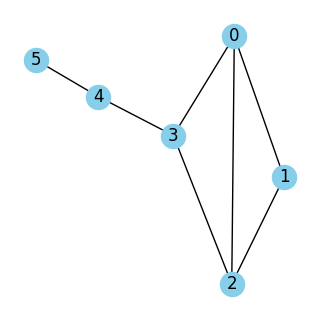

In [257]:
# CREATE A SIMPLE GRAPH
G = nx.Graph()
edges_list = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4), (4, 5)]
G.add_edges_from(edges_list)
plt.figure(figsize=(3, 3))
nx.draw(G, with_labels=True, node_color = 'skyblue')

# GET THE ADJACENCY MATRIX
A = nx.adjacency_matrix(G).toarray()
print(A)

Note that $a_{ij}^n$ gives the number of paths of length $n$ between nodes $i$ and $j$.

In [130]:
path_length = 2
node1, node2 = 2, 1
print(f"Number of paths of length {path_length} between nodes ({node1}, {node2}) is {np.linalg.matrix_power(A, path_length)[node1, node2]}")

Number of paths of length 2 between nodes (2, 1) is 1


<b>Exercise 1:</b> How many paths of length 3 exist between nodes 4 and 5? Is the answer surprising? What are these paths?

### Normalized Adjacency Matrix <a class="anchor" id="A_norm"></a>

Let's first define the degree matrix, which will appear in many definitions in SGT
$$ D_{ij} = \begin{cases} \text{deg}(v_i) & i =j \\
0  & i\neq j \end{cases} $$
The normalized adjacency matrix is defined as
$$A_\text{norm} = D^{-1/2} A D^{-1/2}.$$

In [131]:
def D_minus_half(X):
    ''' Generate the D^(-1/2) matrix from a diagonal matrix X '''
    D = np.zeros(X.shape)
    for i in range(len(X)):
        if X[i,i] != 0:
            D[i,i] = X[i,i]**(-0.5)
        else:
            D[i,i] = 0
    return D

def A_norm(G):
    ''' Generate the normalized adjacency matrix from the graph G '''
    deg_seq = [d for _ , d in G.degree()]
    D = np.diag(deg_seq)
    return D_minus_half(D) @ nx.adjacency_matrix(G).toarray() @ D_minus_half(D)

### Properties of $\mathbf{A}_\text{norm}$ <a class="anchor" id="prop_a_norm"></a>

- $\mathbf{A}_\text{norm}^{T} = \mathbf{A}_\text{norm}$ (which makes it ideal for spectral analysis.)
- All eigenvalues of $\mathbf{A}_\text{norm}$ are within $[-1,1]$.
- $G$ is bipartite if and only if $-1$ is an eigenvalue of $A_\text{norm}$. <br>

It can be shown that a graph $G$ is bipartite if and only if it contains no cycles of odd length. Therefore one eigenvalue says something about all cycles in the graph! 

Bipartite: Do the eigenvalues contain -1? True
Erdos-Renyi: Do the eigenvalues contain -1? False


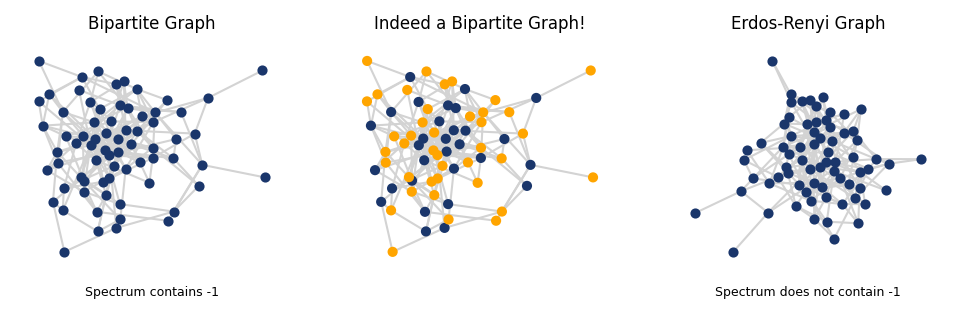

In [450]:
# CREATE A CONNECTED BIPARTITE GRAPH
connected = False
while not connected:
    G_bipartite = nx.bipartite.gnmk_random_graph(30, 40, 190)
    connected = nx.is_connected(G_bipartite)

# VERIFY THE SPECTRUM HAS -1
A_normalized = A_norm(G_bipartite)
vals, vecs = np.linalg.eig(A_normalized)
round_vals = np.round(vals.real, 3)
print(f"Bipartite: Do the eigenvalues contain -1? {-1 in round_vals}")

# CREATE A RANDOM GRAPH (NOT BIPARTITE), AND VERIFY WHETHER THE SPECTRUM HAS -1
connected = False
while not connected:
    G = nx.gnm_random_graph(70, 190)
    connected = nx.is_connected(G)
A_normalized = A_norm(G)
vals, vecs = np.linalg.eig(A_normalized)
round_vals = np.round(vals.real, 3)
print(f"Erdos-Renyi: Do the eigenvalues contain -1? {-1 in round_vals}")

# PLOT THE GRAPHS
fig, ax = plt.subplots(1,3, figsize=(8,2), dpi=150)
pos = nx.spring_layout(G_bipartite, seed = 20)
colors = ['#1a366b' if G_bipartite.nodes[node]['bipartite'] == 0 else 'orange' for node in G_bipartite.nodes()]    
nx.draw(G_bipartite, pos, with_labels=False, node_size=15, node_color = '#1a366b', ax = ax[0], edge_color = 'lightgray')
ax[0].set_title('Bipartite Graph', fontsize=8)
ax[0].text(0.5, -0.1, f"Spectrum contains -1", fontsize=6, ha='center', transform=ax[0].transAxes)

nx.draw(G_bipartite, pos, with_labels=False, node_size=15, node_color = colors, ax = ax[1], edge_color = 'lightgray')
ax[1].set_title('Indeed a Bipartite Graph!', fontsize=8)
nx.draw(G, with_labels=False, node_size=15, node_color = '#1a366b', ax = ax[2], edge_color = 'lightgray')
ax[2].set_title('Erdos-Renyi Graph', fontsize=8);
ax[2].text(0.5, -0.1, f"Spectrum does not contain -1", fontsize=6, ha='center', transform=ax[2].transAxes);

### Community Structure and Fiedler Vector <a class="anchor" id="a_norm_comm"></a>

Community detection is a fundamental problem in network science, aimed at identifying groups of nodes (communities) that are more densely connected internally than with the rest of the network. One popular approach to this problem is modularity maximization, a technique that seeks to optimize a quality function called modularity. Modularity measures the strength of division of a network into communities by comparing the actual density of edges within proposed groups to the expected density in a randomized network with the same degree distribution. Higher modularity values indicate more well-defined community structures. 

Modularity is defined as follows:

$$ M = \frac{1}{2m} \sum_{i,j} \left(A_{ij}-\frac{k_i k_j}{2m}\right) \delta_{g_i,g_j}, $$
where $m$ is the total number of edges, $\delta_{ij}$ is the kronecker-delta function 

It can be shown <a href="https://arxiv.org/abs/1307.7729"> [Newman, 2013]</a> that the Modularity maximization problem for the simple case of two communities can be cast into solving an eigensystem of the following form
$$ (\mathbf{D}^{-1/2}\mathbf{A} \mathbf{D}^{-1/2}) \mathbf{u} = \lambda \mathbf{u},$$
$$ \mathbf{A}_\text{norm} \mathbf{u} = \lambda \mathbf{u}.$$

with the eigenvector corresponding to the second largest eigenvalue of $\mathbf{A}_\text{norm}$ carrying information about nodes assignment to partitions/communities. (The second largest eigenvalue is called <a href="https://en.wikipedia.org/wiki/Algebraic_connectivity">Algebraic Connectivity</a>, and the corresponding eigenvector is called the Fiedler Vector).

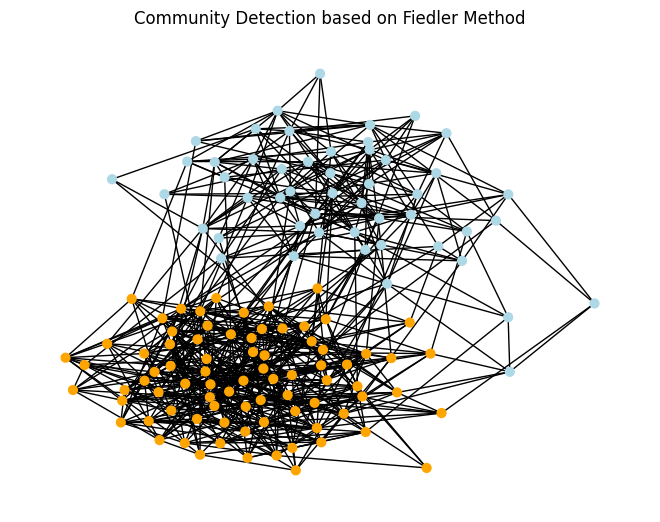

In [547]:
def D_minus_half(X):
    ''' Generate the D^(-1/2) matrix from the diagonal matrix X '''
    D = np.zeros(X.shape)
    for i in range(len(X)):
        if X[i,i] != 0:
            D[i,i] = X[i,i]**(-0.5)
        else:
            D[i,i] = 0
    return D

def fiedler_partitioning_method(G):
    # GET THE NORMALIZED LAPLACIAN MATRIX
    deg_seq = [d for n, d in G.degree()]
    D = np.diag(deg_seq)
    L_normalized = D_minus_half(D) @ nx.adjacency_matrix(G).toarray() @ D_minus_half(D)

    # EXAMINING THE SPECTRUM AND EXTRACTING THE EIGENVECTOR CORRESPONDING TO THE SECOND HIGHEST EIGENVALUE
    rank = 2 # rank of the eigenvector, 1 corresponds to the highest eigenvalue, 2 corresponds to the second highest eigenvalue.. etc.
    precision = 5 # rounding precision of the eigenvalues 
    vals, vecs = np.linalg.eigh(L_normalized)
    rounded_eigenvals = np.round(vals.real, precision)
    index = np.argsort(rounded_eigenvals)[-rank] # index of the second highest eigenvalue
    fiedler_vec = np.round(vecs[:, index], precision)
    assignment = np.sign(fiedler_vec)
    
    # COLOR AND PLOT THE GRAPH ACCORDING TO THE COMMUNITY ASSIGNMENT
    colors = []
    for x in fiedler_vec:
        if x > 0:
            colors.append('orange')
        elif x < 0:
            colors.append('lightblue')
        else:
            colors.append('gray')
    nx.draw(G, with_labels=False, node_color=colors, node_size=40)
    plt.title('Community Detection based on Fiedler Method');
    plt.show()
    return assignment

# GENERATE A GRAPH WITH COMMUNITIES USING STOCHASTIC BLOCK MODEL
G = nx.stochastic_block_model([50, 80], [[0.14, 0.01], [0.01, 0.14]])
comm_assign = fiedler_partitioning_method(G)

What the Fiedler method does is essentially minimizing $\sum_{i=1}^n (x_i - x_j)^2$ subject to the constraints $\sum x_i^2 = n$ and $\sum x_i = 0$, where $x_i$ is the Fiedler value of node $i$. For a closer look at how Fiedler method works under the hood as well as some of its limitations: <a href="https://www.math.umd.edu/~immortal/MATH401/book/ch_graph_theory.pdf"> [Justin Wyss-Gallifent, 2011]</a>

#### Further Resources:
- The Fiedler method can be generalized to include the first k-eigenvectors which can be used to find a useful k-way partition. <a href="https://arxiv.org/pdf/1111.1055"> [James Lee, 2014]</a>
- A paper that explores the relation between the third smallest eigenvalue and graph structure <a href="https://journals.uwyo.edu/index.php/ela/article/download/133/133"> [Pati, 2001] </a>

### Random Walks: <a class="anchor" id="a_norm_random_walk"></a>

<div style="text-align: center;">
  <img src="images/random_walk.jpeg" alt="random_walk" width="300" height="300">
</div>

A simple random walk is a discrete-time stochastic process whose state space is $V$, and the transition probabilities are given by 
$$ p_{ij} = \begin{cases} 0 & i \nsim j \\ 
\frac{1}{d_\text{out}(i)} & i \sim j \end{cases}$$
where the notation $i \sim j$ means there is an edge between vertices $i$ and $j$. That is, the walk jumps between adjacent vertices with equal probability of encountering any vertex adjacent to its current step. The transition matrix can be written as
$$ \mathbf{P} = \mathbf{D}^{-1} \mathbf{A} = \mathbf{D}^{-1/2} \left( \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2} \right) \mathbf{D}^{1/2} = \mathbf{D}^{-1/2} A_\text{norm} \mathbf{D}^{1/2}.$$

It can be proved that an elementary estimate of the rate of convergence of the random walker to the stationary distribution is related to the eigenvalues of the normalized laplacian matrix of the graph.

<!-- $$ \text{Convergence rate} \sim \lambda_2 $$ -->

<b> Result: </b> Let $G$ be a connected and non-bipartite graph, with $A_\text{norm}$ having eigenvalues $\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_n.$ Then we have 
$$ | p_{ij}^{(t)} - \pi_j| \leq |\lambda|^t \sqrt{\frac{d_i}{d_j}},$$
where $\lambda = \max\{|\lambda_2|,|\lambda_n|\}$. 

This means the smaller $\lambda$ is, the faster is the convergence rate!

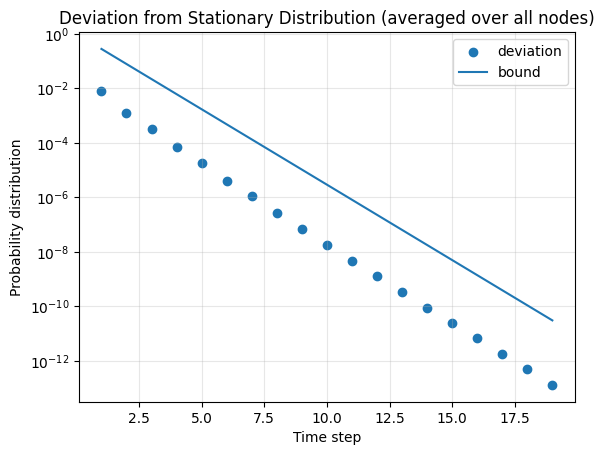

In [554]:
def random_walk_network(G, start_node, steps):
    """
    Simulates a random walk on a network, represented as a graph.

    Starting from the specified node, the walker moves to a randomly selected 
    neighboring node at each step. If the walker reaches an isolated node (one with 
    no neighbors), the walk terminates early.

    Parameters
    ----------
    G : networkx.Graph
        The graph representing the network on which the random walk is performed. 
        Nodes should be connected by edges, as each edge represents a possible transition.
    start_node : node
        The node in G where the random walk starts. Must be a valid node in the graph.
    steps : int
        The number of steps the random walker will attempt to take. Note that the walk 
        may terminate early if an isolated node is reached.

    Returns
    -------
    path : list
        A list of nodes representing the path taken by the walker, starting from 
        `start_node`. The list length will be `steps + 1` unless the walk terminates early 
        at an isolated node.

    Notes
    -----
    - At each step, the walker chooses a neighboring node uniformly at random.
    - If the walker reaches an isolated node (one with no neighbors), the walk stops early.
    - This function assumes the graph `G` is undirected, but it can be adapted for 
      directed networks by modifying the neighbor selection.

    Examples
    --------
    >>> G = nx.path_graph(5)  # Simple path graph with 5 nodes
    >>> random_walk_network(G, start_node=0, steps=10)
    [0, 1, 2, 1, 2, 3, 2, 1, 0, 1, 2]
    """
    # Initialize the path list with the starting node
    path = [start_node]
    
    # Set the current node to the starting node
    current_node = start_node
    
    # Iterate for the specified number of steps
    for _ in range(steps):
        # Get the list of neighbors of the current node
        neighbors = list(G.neighbors(current_node))
        
        # If the current node has neighbors, move to a randomly chosen neighbor
        if neighbors:
            next_node = np.random.choice(neighbors)  # Select a random neighbor
            path.append(next_node)  # Append the selected neighbor to the path
            current_node = next_node  # Update the current node
        else:
            # If no neighbors (isolated node), terminate the walk early
            break

    return path  # Return the full path taken by the walker

# GENERATE A CONNECTED ERDOS-RENYI GRAPH
n = 200
p = 0.2
connected = False
while not connected:
    G = nx.erdos_renyi_graph(n, p)
    connected = nx.is_connected(G)

# GET THE MATRICES ASSOCIATED WITH THE GRAPH
A = nx.adjacency_matrix(G).toarray() # adjacency matrix
A_normalized = A_norm(G) # normalized adjacency matrix
d = np.sum(A, axis=1) # degree of each node
pi = d / np.sum(d) # stationary distribution of the random walk
D = np.diag(d) # degree matrix
P = np.linalg.inv(D) @ A # transition matrix of the random walk

# GET THE SECOND HIGHEST EIGENVALUE 
vals, vecs = np.linalg.eigh(A_normalized)
round_vals = np.round(vals.real, 3)
round_vals = sorted(round_vals)
lam = max([np.abs(round_vals[-2]), np.abs(round_vals[0])])

# nx.draw(G, with_labels=True)

# CALCULATING BOTH SIDES OF THE INEQUALITY
time_steps = 20
i, j = 10, 3
time_axis = list(range(1, time_steps))
lhs, rhs = [], []
for t in time_axis:
    yl = 0
    yr = 0
    for node in list(G.nodes()):
        yl += np.abs(np.linalg.matrix_power(P, t)[i, node] - pi[node])
        yr += np.abs(lam)**t * np.sqrt(d[i]/d[node])
    lhs.append(yl/n)
    rhs.append(yr/n)
plt.scatter(time_axis, lhs, label = "deviation")
plt.plot(time_axis, rhs, label = "bound")
plt.yscale('log')
# plt.ylim(0, 0.1)
plt.xlabel('Time step')
plt.ylabel('Probability distribution')
plt.title('Deviation from Stationary Distribution (averaged over all nodes)')
plt.legend()
plt.grid(alpha = 0.3)

<b>Exercise 2:</b> What are some examples of graphs that have low convergence rate (slow mixing)?

#### References:
[1] Sawyer Jack Robertson (2020): A Survey of Random Walks on Networks https://mathweb.ucsd.edu/~s5robert/documents/random_walks.pdf

## Chapter 3: Laplacian Matrix <a id="ch3"></a>

### Definition <a class="anchor" id="lap_definition"></a>

The Laplacian matrix $L$ of a graph is a key mathematical representation used in spectral graph theory to analyze the structure and properties of a graph. 
It is defined as
$$ L_{ij} = \begin{cases} -1 & \text{if} \ (i,j) \in E, \\
k_i & \text{if} \ i = j, \\
0 & \text{otherwise}. \\
\end{cases} $$

or more succintly as
$$ L = D - A.$$

[[ 3 -1 -1 -1  0  0]
 [-1  2 -1  0  0  0]
 [-1 -1  3 -1  0  0]
 [-1  0 -1  3 -1  0]
 [ 0  0  0 -1  2 -1]
 [ 0  0  0  0 -1  1]]


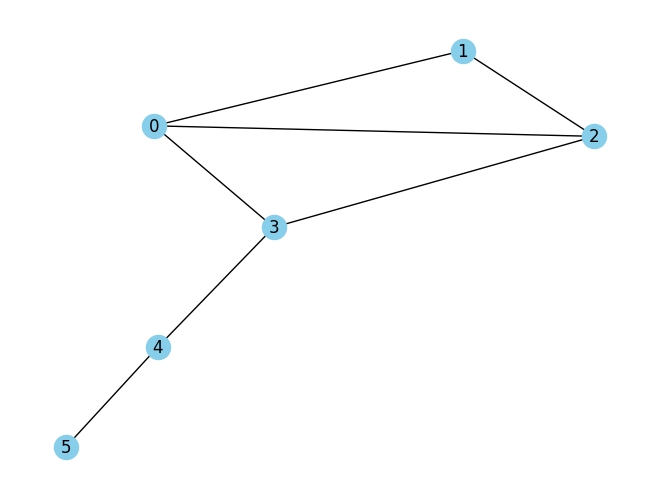

In [555]:
G = nx.Graph()
edges_list = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4), (4, 5)]
G.add_edges_from(edges_list)
nx.draw(G, with_labels=True, node_color = 'skyblue')
L = nx.laplacian_matrix(G).toarray()
print(L)

### Properties of $\mathbf{L}_\text{norm}$: <a class="anchor" id="prop_l_norm"></a>

Let the eigenvalues of a Laplacian matrix of size $n \times n$ be $$ \lambda_1 \leq \lambda_2 \leq ... \leq \lambda_n.$$
1- Since $L$ is symmetric, $\lambda_i$ is real. <br>
2- $\lambda_i \geq 0, \ \forall i$. <br>
3- $\lambda_1 = 0 $. Multiplicity of $\lambda_1$ = number of connected components. <br>
4- A graph $G$ is connected if and only if $\lambda_2>0$.

Eigenvalues are: [ 6.471 -0.     1.098  0.896  2.574  3.661  4.     5.301  0.     0.   ]

The multiplicity of zero = 3
The number of connected components = 3


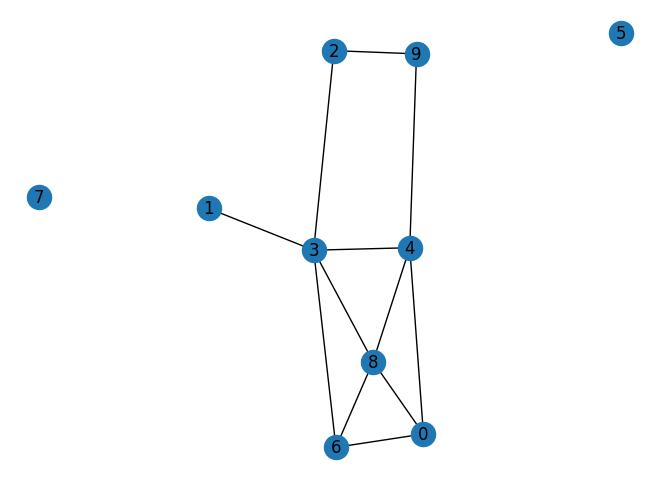

In [564]:
# CREATE A RANDOM GRAPH
G = nx.erdos_renyi_graph(10, 0.2)
pos = nx.spring_layout(G, k = 0.7)
nx.draw(G, pos, with_labels=True)

# GET THE LAPLACIAN MATRIX
L = nx.laplacian_matrix(G).toarray()
eigenvalues = np.linalg.eigvals(L)
round_vals = np.round(eigenvalues.real, 3)
print(f"Eigenvalues are: {round_vals}\n")

# COUNT THE NUMBER OF ZERO EIGENVALUES AND COMPARE WITH NUMBER OF CONNECTED COMPONENTS
zero_count = np.count_nonzero(round_vals == 0)
print(f"The multiplicity of zero = {zero_count}")
print(f"The number of connected components = {len(list(nx.connected_components(G)))}")

### Laplacian Spectrum of Famous Graphs <a class="anchor" id="laplacian_spectrum"></a>

- The Laplacian of $K_n$ has eigenvalue 0 with multiplicity 1 and eigenvalue $n$ with multiplicity $n-1$.
- The Laplacian of $C_n$ has eigenvalues $2-2 \cos{(\frac{2\pi k}{n})} $.
- The Laplacian of $P_n$ has the same eigenvalues as $C_{2n} = 2-2 \cos{(\frac{\pi k}{n})}$.

In [470]:
n = 20

# COMPLETE GRAPH
G_complete = nx.complete_graph(n)
L_complete = nx.laplacian_matrix(G_complete).toarray()
print(f"Eigenvalues of the complete graph: {np.round(np.linalg.eigvals(L_complete).real, 3)}")

Eigenvalues of the complete graph: [-0. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20.]


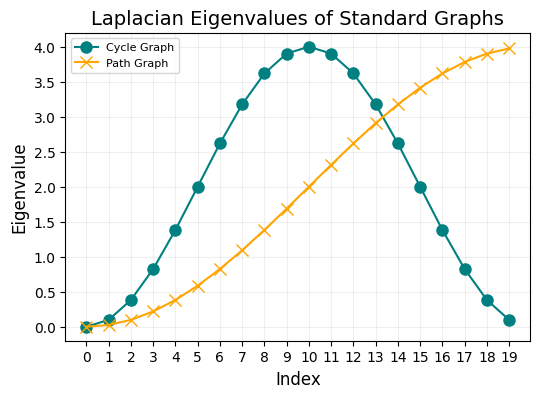

In [ ]:
n = 20
# CYCLE AND PATH GRAPHS
G_cycle = nx.cycle_graph(n)
L_cycle = nx.laplacian_matrix(G_cycle).toarray()

G_path = nx.path_graph(n)
L_path = nx.laplacian_matrix(G_path).toarray()

G_er = nx.erdos_renyi_graph(n, 0.2)
L_er = nx.laplacian_matrix(G_er).toarray()

eigvals_cycle, eigvec_cycle = np.linalg.eig(L_cycle)
eigvals_cycle = eigvals_cycle.real

eigvals_path, eigvec_path = np.linalg.eig(L_path)
eigvals_path = eigvals_path.real

eigvals_er, eigvec_er = np.linalg.eig(L_er)
eigvals_er = eigvals_er.real

# THEORETICAL EIGENVALUES
theoretical_eigvals_cycle = [2 * (1 - np.cos(2 * np.pi * k / n)) for k in range(n)]
theoretical_eigvals_path = [2 * (1 - np.cos(np.pi * k / n)) for k in range(n)]

# The order of computed eigenvalues might not match the theoretical values, so we rearrange them based on their proximity to the theoretical values.
matched_indices_cycle = [np.argmin(np.abs(eigvals_cycle - theo_val)) for theo_val in theoretical_eigvals_cycle]
matched_eigvals_cycle = eigvals_cycle[matched_indices_cycle]

matched_indices_path = [np.argmin(np.abs(eigvals_path - theo_val)) for theo_val in theoretical_eigvals_path]
matched_eigvals_path = eigvals_path[matched_indices_path]

# PLOT THE EIGENVALUES
plt.figure(figsize=(6, 4))
plt.plot(range(n), matched_eigvals_cycle, 'o-', label='Cycle Graph', markersize=8, color = 'teal')
plt.plot(range(n), matched_eigvals_path, 'x-', label='Path Graph', markersize=8, color = 'orange')
plt.title('Laplacian Eigenvalues of Standard Graphs', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.xticks(ticks=np.arange(0, len(range(n)), step=1), labels=np.arange(0, len(range(n)), step=1))
plt.legend(fontsize=8)
plt.grid(alpha=0.2)
plt.show()

Laplacian Spectrum of Erdos-Renyi Graph and Barabasi-Albert graph: <br>
Notice the BA eigenvalues are much smaller than ER graphs, with the latter centering around $\lambda=np$.

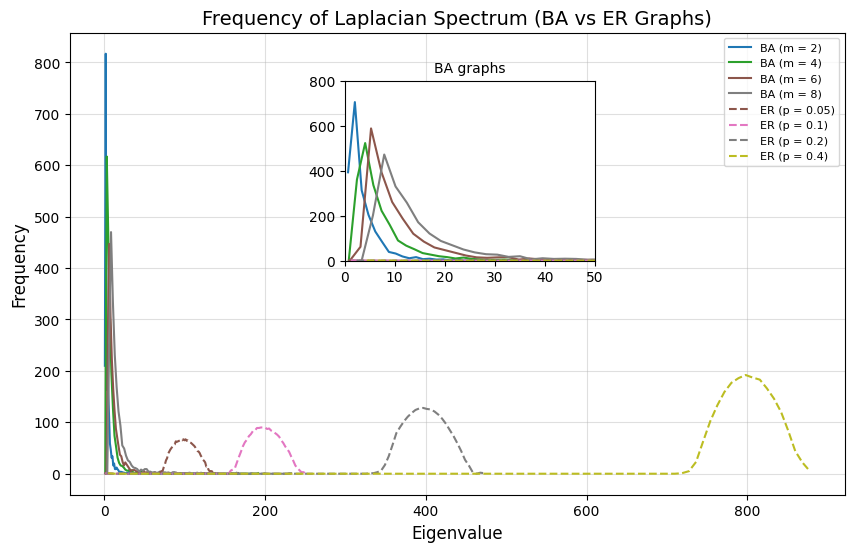

In [ ]:
from matplotlib import colormaps

# Parameters for ER and BA graphs
n = 2000 
p_values = [0.05, 0.1, 0.2, 0.4]  # Different probabilities for ER graphs
m_values = [2, 4, 6, 8]  # Different values of m for BA graphs
bins = 100 

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Laplacian spectrum for BA graphs
palette = colormaps["tab10"]
for idx, m in enumerate(m_values):
    G = nx.barabasi_albert_graph(n, m)
    L = nx.laplacian_matrix(G).toarray()
    eigenvalues = np.linalg.eigvalsh(L)

    # Plot the binned frequency
    counts, bin_edges = np.histogram(eigenvalues, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    ax.plot(bin_centers, counts, label=f"BA (m = {m})", color=palette(idx / len(m_values)))

# Plot Laplacian spectrum for ER graphs
for idx, p in enumerate(p_values):
    G = nx.erdos_renyi_graph(n, p)
    L = nx.laplacian_matrix(G).toarray()
    eigenvalues = np.linalg.eigvalsh(L)

    # Plot the binned frequency
    counts, bin_edges = np.histogram(eigenvalues, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    ax.plot(bin_centers, counts, label=f"ER (p = {p})", linestyle="--", color=palette((idx + len(m_values)) / (len(m_values) + len(p_values))))

# Create an inset to zoom in on the BA part of the x-axis
inset_ax = fig.add_axes([0.4, 0.5, 0.25, 0.3])
for idx, m in enumerate(m_values):
    G = nx.barabasi_albert_graph(n, m)
    L = nx.laplacian_matrix(G).toarray()
    eigenvalues = np.linalg.eigvalsh(L)

    # Plot the binned frequency
    counts, bin_edges = np.histogram(eigenvalues, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    inset_ax.plot(bin_centers, counts, label=f"BA (m = {m})", color=palette(idx / len(m_values)))

for idx, p in enumerate(p_values):
    G = nx.erdos_renyi_graph(n, p)
    L = nx.laplacian_matrix(G).toarray()
    eigenvalues = np.linalg.eigvalsh(L)

    # Plot the binned frequency
    counts, bin_edges = np.histogram(eigenvalues, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    inset_ax.plot(bin_centers, counts, linestyle="--", color=palette((idx + len(m_values)) / (len(m_values) + len(p_values))))

# Inset plot settings
inset_ax.set_xlim(0, 50)
inset_ax.set_ylim(0, 800)
inset_ax.set_title("BA graphs", fontsize=10)

# Main plot settings
ax.set_title("Frequency of Laplacian Spectrum (BA vs ER Graphs)", fontsize=14)
ax.set_xlabel("Eigenvalue", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.legend(fontsize=8, loc="upper right")
ax.grid(alpha=0.4)

plt.show()

### Relation between normalized Laplacian and normalized adjacency matrix: <a class="anchor" id="relation"></a>

The two matrices are closely related 
$$ \mathbf{L}_\text{norm} = \mathbf{D}^{-1/2} \mathbf{L} \mathbf{D}^{-1/2} = \mathbf{D}^{-1/2} (\mathbf{D} - \mathbf{A}) \mathbf{D}^{-1/2} = \mathbf{I} - \mathbf{A}_\text{norm}.$$ 

Therefore, if $\lambda$ is an eigenvalue of the matrix $\mathbf{A}_\text{norm}$ then $1-\lambda$ is an eigenvalue of $\mathbf{L}_\text{norm}$.

Note that authors use 'Normalized Laplacian' to denote either of them depending on the context!

### Bottlenecks, Sparse Cuts and Cheeger's Inequality <a class="anchor" id="sparse-cuts"></a>

<div style="text-align: center;">
  <img src="images/sparse-cut.png" alt="Snowfall" width="400" height="400">
</div>

Recall from above that a graph $G$ is connected if and only if $\lambda_2 > 0$, where $\lambda_2$ is the second smallest eigenvalue of the normalized laplacian matrix. In this section, we will see the generalization that $\lambda_2$ is large if and only if the graph is well-connected. Can we quantify this? Let's define the idea of conductance.
#### Conductance
Let $G=(V,E)$ be an undirected graph, and $S \subseteq V$. The conductance of the subset $S$ can be defined as 

$$ \phi(S) = \frac{|\partial S|}{\text{vol}(S)}, $$
where $\partial S$ denotes the set of edges with one endpoint in $S$ and one endpoint in $V-S$, $\text{vol}(S) = \sum_{v\in S} \text{deg}(v)$. That is, the conductance of a subset $S$ is the ratio between edges that are cut by $S$ to the total degree in $S$.

Additionally, the conductance of a graph $G$ can be defined as 
$$ \phi(G) = \min_{S:\text{vol}(S)\leq |E|}{\phi(S)}, $$
that is, the minimum conductance over all possible subsets $S$ of the graph such that the number of edges within $S$ is roughly no more than half the total number of edges.
Notice that this definition of conductance tries to capture the 'bottleneck' in the graphs. A small $\phi(S)$ corresponds to a collection of vertices that are sparsely connected to the rest of the graph and may represent a cluster.

<b> Exercises: </b> <br>
1- It's true that $ 0 < \phi(S) < 1$, can you see why? <br>
2- Why do you think the definition has the condition $\text{vol}(S) \leq |E|$? (Hint: If the subset $S$ is a sparse cut of the graph, what can we say about the complement subset $V-S$?) <br>
3- What's the conductance of a complete graph?

In [ ]:
import itertools

def compute_conductance(G, subset):
    ''' A function to compute the conductance of a subset of nodes in a graph G
     
    Parameters:
    ----------
    G: networkx.Graph
    subset: set of nodes in the graph G
      
    Returns:
    ----------
    conductance: float
    '''

    S = set(subset)
    S_bar = set(G.nodes) - S
    cut = sum(1 for (u, v) in G.edges if (u in S and v in S_bar) or (u in S_bar and v in S))
    vol_S = sum(G.degree[node] for node in S)
    vol_S_bar = sum(G.degree[node] for node in S_bar)
    return cut / min(vol_S, vol_S_bar)

# BRUTE FORCE: SEARCH OVER SUBSETS
def brute_force_conductance(G):
    ''' A function to compute the conductance of the best partition of a graph G using brute force search
    
    Parameters:
    ----------
    G: networkx.Graph
    
    Returns:
    ----------
    min_conductance: float
    '''

    nodes = list(G.nodes)
    min_conductance = float('inf')
    for i in range(1, len(nodes) // 2 + 1):
        subsets = [set(subset) for subset in itertools.combinations(nodes, i)]
        for subset in subsets:
            phi = compute_conductance(G, subset)
            min_conductance = min(min_conductance, phi)
    return min_conductance

# FOR LARGE GRAPHS, USE HEURISTICS (e.g., Fiedler vector)
def fiedler_partition_conductance(G):
    ''' A function to compute the conductance of the best partition of a graph G using the Fiedler vector

    Parameters:
    ----------
    G: networkx.Graph

    Returns:
    ----------
    conductance: float
    '''
    
    L = nx.normalized_laplacian_matrix(G).toarray()
    eigvals, eigvecs = np.linalg.eigh(L)
    fiedler_vector = eigvecs[:, 1]  # Fiedler vector
    median = np.median(fiedler_vector)
    S = {node for node, value in zip(G.nodes, fiedler_vector) if value <= median}
    return compute_conductance(G, S)

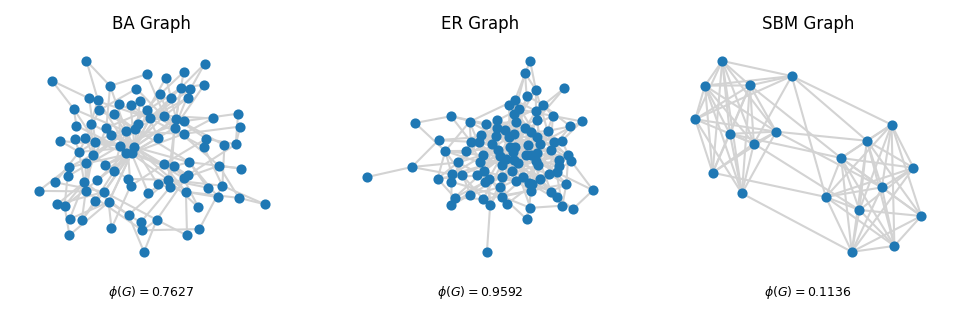

In [570]:
connected = False
while not connected:
    G1 = nx.barabasi_albert_graph(100, 2)
    G2 = nx.erdos_renyi_graph(100, 0.05)
    G3 = nx.stochastic_block_model([10, 10], [[0.9, 0.1], [0.1, 0.9]], seed=0)
    connected = nx.is_connected(G1) and nx.is_connected(G2) and nx.is_connected(G3)

conductance1 = fiedler_partition_conductance(G1)
conductance2 = fiedler_partition_conductance(G2)
conductance3 = fiedler_partition_conductance(G3)

# PLOT THE GRAPHS
fig, ax = plt.subplots(1,3, figsize=(8,2), dpi=150)
nx.draw(G1, with_labels=False, node_size=15, ax = ax[0], edge_color = 'lightgray')
ax[0].set_title('BA Graph', fontsize=8)
ax[0].text(0.5, -0.1, f"$\phi(G)= ${np.round(conductance1, 4)}", fontsize=6, ha='center', transform=ax[0].transAxes)

nx.draw(G2, with_labels=False, node_size=15, ax = ax[1], edge_color = 'lightgray')
ax[1].set_title('ER Graph', fontsize=8)
ax[1].text(0.5, -0.1, f"$\phi(G)= ${np.round(conductance2, 4)}", fontsize=6, ha='center', transform=ax[1].transAxes)

nx.draw(G3, with_labels=False, node_size=15, ax = ax[2], edge_color = 'lightgray')
ax[2].set_title('SBM Graph', fontsize=8);
ax[2].text(0.5, -0.1, f"$\phi(G)= ${np.round(conductance3, 4)}", fontsize=6, ha='center', transform=ax[2].transAxes);

#### Cheeger's Inequality
The following important inequality can be proved 
$$ \frac{1}{2} \lambda_2 \leq \phi(G) \leq \sqrt{2 \lambda_2}.$$
The second eigenvalue bounds the graph conductance!!

In [576]:
import itertools

G = nx.stochastic_block_model([10, 10], [[0.9, 0.1], [0.1, 0.9]])
L = nx.normalized_laplacian_matrix(G).toarray()
eigvals, eigvecs = np.linalg.eigh(L)
lambda_2 = eigvals[1]  # Second smallest eigenvalue

print(f"Second smallest eigenvalue (λ2): {lambda_2}")

# NOW WE COMPARE SPECTRAL GAP AND CONDUCTANCE
phi_G = fiedler_partition_conductance(G)
print(f"Estimated conductance (φ): {phi_G}")
print(f"Cheeger's bounds:")
print(f"{lambda_2 / 2} ≤ {phi_G} ≤ {np.sqrt(2 * lambda_2)}")

Second smallest eigenvalue (λ2): 0.17949655117817687
Estimated conductance (φ): 0.0989010989010989
Cheeger's bounds:
0.08974827558908843 ≤ 0.0989010989010989 ≤ 0.5991603310937347


### Optimization formulation for $\lambda_2$: <a class="anchor" id="optimization"></a>

But what if we have a very large network, do we have to find the whole spectrum of $\mathbf{L}_\text{norm}$ to know $\lambda_2$? Fortunately, the answer is no. The problem of finding $\lambda_2$ can be obtained as an optimization problem of a quadratic form (called Rayleigh Quotient) as follows:
$$ \lambda_2 = \min_{x\in \R^n:x \perp \mathbf{1}}{\frac{x^T \mathbf{L}_\text{norm} x}{x^T x}} $$

Advantages:
- Scalability: can be faster for very large graphs
- Customizability: we can find the eigenvalues of modified Laplacians by changing the constraints.
- You don't need to find the full spectrum!

#### References:
1- Cheeger's Inequality - Lap Chi Lau https://cs.uwaterloo.ca/~lapchi/cs860/notes/04-Cheeger.pdf

## Chapter 4: Non-Backtracking Matrix <a id="ch4"></a>

### Definition <a class="anchor" id="nb-definition"></a>

- <b>For a directed graph:</b> of size $n$ and number of edges $m$, Non-backtracking matrix is an $m \times m$ matrix (note it's indexed by edges, not nodes), defined as follows:
    $$ B_{ij} = \begin{cases}
            1 & \text{if edge $i$ ends where edge $j$ starts} \\
            0 & \text{otherwise} \\
        \end{cases} $$
    or $$B_{(j \to i), (l \to k)}=\delta_{jk}(1-\delta_{il}).$$
- <b>For undirected graphs:</b> we treat each edge between two vertices $(i,j)$ as two directed edges $(i\to j), (j \to i)$, and apply the same definition above (therefore for an undirected graph with number of edges $m$, $\mathbf{B}$ matrix will be of size $2m \times 2m$).

- Non-backtracking walk: is a walk on a graph where $v_i$ can be chosen uniformly from the set of neighbours of $v_{i-1}$, excluding $v_{i-2}$ (no edge is traversed twice in succession).

- $B^k_{ij}$ gives the number of walks of length $k+1$ that start from edge $i$ and end on edge $j$ that satisfy the non-backtracking condition.

[Your Turn!] Implement the definition of non-backtracking matrix above for directed graphs.

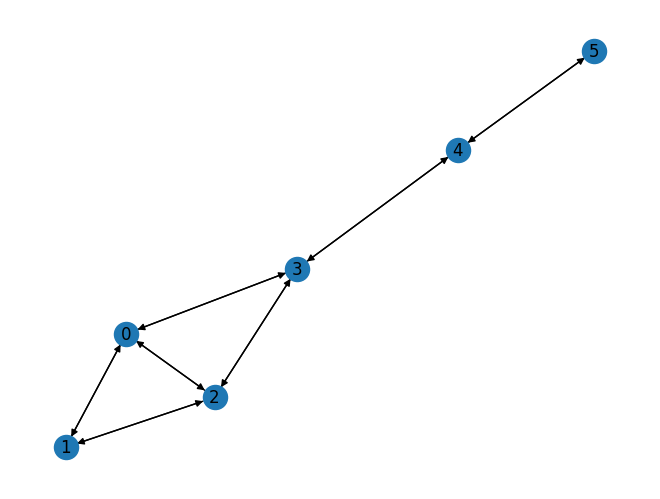

In [ ]:
# Your turn!

def nonbacktracking_matrix(G):
    """ calculates the non-backtracking matrix of a graph G (notice the order of the edges is important)
    defined only for directed graphs.

    NOTE: list(G.edges()) changes the order of the edges_list used to construct the graph
    (orders ascendingly according to the first coordinate of the edge tuples).
    So we return it to keep track of the indices of the edges! 
    (or alternatively we can sort the edges_list before feeding it into nx.Graph)

    Input 
    G (nx.Graph): a Networkx graph

    Output
    B: numpy array of size m x m, non-backtracking matrix of the graph
    edge_list: list of edges of the graph
    """

    # Step 1: get the edges list of the graph


    # Step 2: initialize the non-backtracking matrix B (what's the size of B again?)


    # Step 3: fill in the non-backtracking matrix B by looping over the edges twice! (Hint: you might find 'enumerate' useful)


    return B, edge_list
G = nx.DiGraph()
edges_list = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4), (4, 5), (1, 0), (2, 0), (3, 0), (2, 1), (3, 2), (4, 3), (5, 4)]
G.add_edges_from(edges_list)
nx.draw(G, with_labels=True)
B, edges_list = nonbacktracking_matrix(G)
# print(B)

In [300]:
path_length = 5
edge1 = (5, 4)
edge2 = (0, 1)
edge1_idx, edge2_idx = edges_list.index(edge1), edges_list.index(edge2)
print(f"Number of paths of length {path_length} between edges {edge1} and {edge2} is {round(np.linalg.matrix_power(B, path_length-1)[edge1_idx, edge2_idx])}")

Number of paths of length 5 between edges (5, 4) and (0, 1) is 1


### Applications of the non-backtracking matrix: <a class="anchor" id="nb-applications"></a>
- the site percolation threshold of an infinite graph is approximated by the inverse of the largest NB-eigenvalue $\lambda_1$. <a href="https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.113.208701"> [Hamilton & Pryadko 2014] </a>
- Targeted Node Immunization strategies to increase epidemic threshold have been shown to be related to the spectrum of NB matrix. <a href="https://arxiv.org/abs/2002.12309"> [Torres et al, 2020] </a>

### Resources:

- <a href="http://cs-www.cs.yale.edu/homes/spielman/sagt/sagt.pdf">'Spectral and Algebraic Graph Theory' - Daniel A. Spielman </a>
- <a href="https://cs.uwaterloo.ca/~lapchi/cs860/">'CS 860: Eigenvalues and Polynomials' by Prof Lap Chi Lau, University of Toronto </a>
- <a href="https://sites.google.com/site/spectralgraphtheory/">A website with a compilation of applications of spectral graph theory, created and maintained by Steve Butler </a>

## Answers to Exercises:

In [ ]:
def nonbacktracking_matrix(G):
    """ calculates the non-backtracking matrix of a graph G (notice the order of the edges is important)
    defined only for directed graphs.

    NOTE: list(G.edges()) changes the order of the edges_list used to construct the graph
    (orders ascendingly according to the first coordinate of the edge tuples).
    So we return it to keep track of the indices of the edges! 
    (or alternatively we can sort the edges_list before feeding it into nx.Graph)

    Input 
    G (nx.Graph): a Networkx graph

    Output
    B: numpy array of size m x m, non-backtracking matrix of the graph
    """
    # Step 1: get the edges list of the graph
    edge_list = list(G.edges())

    # Step 2: initialize the non-backtracking matrix B (what's the size of B again?)
    m = len(edge_list)
    B = np.zeros((m, m))

    # Step 3: fill in the non-backtracking matrix B by looping over the edges twice! (Hint: you might find 'enumerate' useful)
    for i, (u, v) in enumerate(edge_list):
        for j, (x, y) in enumerate(edge_list):
            if v == x and u != y: 
                B[i, j] = 1
    return B, edge_list